## Research and cross validation

In [1]:
!nvidia-smi

Fri Feb  1 16:37:52 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.78       Driver Version: 410.78       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:03:00.0 Off |                  N/A |
| 22%   36C    P0    39W / 180W |      0MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:04:00.0 Off |                  N/A |
| 22%   38C    P0    40W / 180W |      0MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [21]:
%env CUDA_VISIBLE_DEVICES=0, 1, 2, 3

env: CUDA_VISIBLE_DEVICES=0, 1, 2, 3


In [22]:
import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
from copy import deepcopy
from itertools import combinations
sys.path.insert(0, os.path.join('..'))

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from radial.batchflow import Dataset, FilesIndex, Pipeline, R, B, V, C, action
from radial.batchflow.models.tf import TFModel

from radial.batchflow.research import Research, Option
from radial.batchflow.research.research import Executable

from radial.core import RadialBatch, RadialImagesBatch
from radial.core.pipelines import create_load_ppl

from research_utils import *
plt.style.use('ggplot')
%matplotlib inline

## Подготовка данных
если хотите обучать пайплайны по кросс валидации, напишите количество бинов в `cross_val` иначе будет происходить стандартное разделение на train/test.

In [23]:
import random

class TmpBatch(RadialImagesBatch):
    @action
    def hard_negative_sampling(self, statistics_name=None, fraction=0.5):
        btch_size = len(self.indices)
        if statistics_name and type(self.pipeline.get_variable(statistics_name)) == dict:
            loss_history_dict = self.pipeline.get_variable(statistics_name)

            sorted_by_value = sorted(loss_history_dict.items(), key=lambda kv: kv[1])
            hard_count = int(btch_size * fraction)
            hard_indices = sorted_by_value[:hard_count]
            new_index = list(self.indices[: btch_size - hard_count]) + [x[0] for x in hard_indices]
            random.shuffle(new_index)
            batch = TmpBatch(index=self.pipeline.dataset.index.create_subset(new_index))
            return batch
        else:
            return self

    @action
    def update_loss_history_dict(self, src='loss_history', dst='loss_history_dict'):
        new_loss_history_dict = dict(zip(self.index.indices, self.pipeline.get_variable(src)))
        if type(self.pipeline.get_variable(dst)) == dict:
            new_loss_history_dict = {**new_loss_history_dict, **self.pipeline.get_variable(dst)}
        self.pipeline.update_variable(dst, new_loss_history_dict,
                                      mode='w')
        return self

In [24]:
cross_val = 1
path = 'npz_data/train_npz/*.npz'

dataset = create_datasets(path, TmpBatch, cross_val)

# Создание пайплайнов
Напиши сюда свой конфиг и свои пайпалйны.

In [25]:
N_SAMPLES = 50

# model_config = {
#     'inputs': dict(points=dict(shape=(2, N_SAMPLES)),
#                    targets=dict(name='target', shape=1)),
#     'initial_block/inputs': 'points',
#     'head': dict(layout='f',
#                  units=1),
#     'body/num_blocks': C('num_blocks'),
#     'body/filters': C('bla'),
#     'initial_block/filters': C('filters'),
#     'loss': 'mse',
#     'optimizer': 'Adam'
# }

model_config = {
    'inputs': dict(images=dict(shape=(180, 270, 1)),
                             labels={'shape': (1), 'name': 'targets'}),
    'body': dict(layout='cpna cpna cpna cpna cpna cpna cpna', filters=[16, 16, 16, 32, 64, 128, 128],
                 strides=1, pool_strides=2, kernel_size=C('kernel_size'), dilation_rate=C('dilation_rate')),
    'head': dict(layout='Pf', units=1),
    'initial_block/inputs': 'images',
    'loss': 'mse',
#     'optimizer': 'Adam'}
    'optimizer': 'Adam'}

In [36]:
B_SIZE = 16
# тут создаем пайплайны для трейна и теста ресерча, без загрузки данных.
# NOTE: не забудте добавить run с параметром lazy=True!

# prep_pipeline = create_preprocess_pipeline(N_SAMPLES, np.random.random)
# train_pipeline = create_train_pipeline(C('model'), model_config, prep_pipeline).run(B_SIZE, n_epochs=None, drop_last=True, lazy=True)

# test_pipeline = prep_pipeline + (Pipeline()
#                         .init_variable('predictions', init_on_each_run=list)
#                         .init_variable('targets', init_on_each_run=list)
#                         .import_model('model', C('import_from'))
#                         .update_variable('targets', B('target'), mode='e')
#                         .predict_model('model', fetches='predictions',
#                                                 feed_dict={'points': B('points'),
#                                                            'targets': B('target')},
#                                         save_to=V('predictions'), mode='e')
#                         .run(B_SIZE, n_epochs=1, drop_last=True, lazy=True)
# )

image_index = FilesIndex(path='bold_data/*.png', no_ext=True)
# load_ppl = create_load_ppl(image_index)
def log(*args):
    return np.array(list(map(np.log10, args)))



load_ppl = (Pipeline()
                .init_variable('loss_history_dict', init_on_each_run=0)
                .hard_negative_sampling(statistics_name='loss_history_dict', fraction=0.33)
                .load(fmt='npz')
                .drop_negative()
                .apply_transform(log, src=['time', 'derivative', 'target'], dst=['log_time', 'log_derivative', 'log_target'])
                .normalize(src=['log_time', 'log_derivative'], dst=['log_norm_time', 'log_norm_derivative'],\
                           dst_range=[None, 'derivative_range'])
                .normalize(src='log_target', dst='log_norm_target', src_range='derivative_range')
                .load(fmt='image', src=image_index, components='images')
                .resize((300, 200))
                .crop(origin='center', shape=(270, 180))
                .to_array()
                .multiply(1/255.)
                .load(fmt='csv', src='targets.csv', components='target', index_col='index')
                .expand_dims(src='log_norm_target')
                .expand_dims(src='target'))

train_pipeline = (load_ppl + 
                  Pipeline()
                 .init_variable('loss')
                 .init_variable('mean_loss_history', init_on_each_run=list)
                 .init_variable('loss_history', init_on_each_run=0)
                 .init_model('dynamic', TFModel, 'model', config=model_config)
                 .train_model('model', fetches=['loss', 'TFModel/mean_squared_error/SquaredDifference:0'],
                           feed_dict={'images': B('images'),
                                      'labels': B('target')}, 
                           save_to=[V('loss'), V('loss_history')], mode='w')
                 .update_variable('mean_loss_history', V('loss'), mode='a')
                 .update_loss_history_dict()).run(B_SIZE, n_epochs=None, drop_last=True, lazy=True)


test_pipeline = (load_ppl + 
                 Pipeline()
                  .init_variable('loss', init_on_each_run=0)
                  .init_variable('loss_history', init_on_each_run=list)
                  .init_variable('targets', init_on_each_run=list)
                  .init_variable('predictions', init_on_each_run=list)
                  .import_model('model', C('import_from'))
                  .predict_model('model', fetches='predictions',
                               feed_dict={'images': B('images'),
                                          'labels': B('target')},
                               save_to=B('predictions'), mode='w')
                  .update_variable('loss_history', V('loss'), mode='a')
                  .denormalize(src='predictions', dst='denorm_predictions',
                               src_range='derivative_range')
                  .update_variable('targets', B('log_target'), mode='e')
                  .update_variable('predictions', B('denorm_predictions'), mode='e')
                ).run(B_SIZE, n_epochs=1, drop_last=True, lazy=True)

# Метрики
По дефолту будем считать метрики mape и котежеков-like

In [37]:
def get_mape(iteration, experiment, pipeline):
    """ Calculate mean absolute percentage error."""
    _ = iteration
    pipeline = experiment[pipeline].pipeline
    y_pred = np.array(pipeline.get_variable('predictions')).reshape(-1)
    y_true = np.array(pipeline.get_variable('targets')).reshape(-1)
    return np.mean(np.abs(y_true-y_pred)/y_true)

def get_mape30(iteration, experiment, pipeline):
    """ Calculate percentage of mean absolute percentage error which less than 30%."""
    _ = iteration
    pipeline = experiment[pipeline].pipeline
    y_pred = np.array(pipeline.get_variable('predictions')).reshape(-1)
    y_true = np.array(pipeline.get_variable('targets')).reshape(-1)
    ape = np.abs(y_true-y_pred)/y_true
    return np.mean(ape < 0.3)*100

# сохраним обученные модели
def save_model(iteration, experiment, pipeline, model_name, path='./'):
    """ Save model to a path."""
    path = os.path.join(path, experiment[pipeline].config.alias(as_string=True) + '_' + str(iteration))
    pipeline = experiment[pipeline].pipeline
    pipeline.save_model(model_name, path)
    return

def get_ape(iteration, experiment, pipeline):
    """ Calculate percentage of absolute percentage error."""
    _ = iteration
    pipeline = experiment[pipeline].pipeline
    y_pred = np.array(pipeline.get_variable('predictions')).reshape(-1)
    y_true = np.array(pipeline.get_variable('targets')).reshape(-1)
    return np.abs(y_true-y_pred)/y_true

In [38]:
# train_pipeline = (train_pipeline << dataset.train)
# test_pipeline = (test_pipeline << dataset.test)

In [39]:
# train_pipeline.next_batch(10)
# test_pipeline.next_batch(10)

In [40]:
# test_pipeline.get_variable('predictions')

## Создание Research
Тут напиши свой объект research и набор параметров.

In [41]:
# измени на свои параметры
# opts = Option('model', [ResNet18]) \
#        * Option('filters', [2, 4, 8]) * Option('bla', [[8, 16, 32]]) * Option('num_blocks', [[1, 1, 1]])
opts = Option('kernel_size', [[22, 22, 11, 9, 7, 3, 3], [22, 11, 9, 7, 3, 3, 3]]) * \
        Option('dilation_rate', [[2, 2, 1, 1, 1, 1, 1], [2, 2, 2, 2, 1, 1, 1]])

# opts = Option('kernel_size', [[22, 22, 11, 9, 7, 3, 3]]) * \
#         Option('dilation_rate', [[2, 2, 1, 1, 1, 1, 1]])

    
research = (Research()
            .pipeline(train_pipeline, variables='loss', name='train')
            .pipeline(test_pipeline, name='test', execute='%5',
                      run=True, import_from='train')    
            .grid(opts)
            .function(get_mape, returns='metrics', name='test_mape',
                      execute='%5', pipeline='test')
            .function(get_mape30, returns='metrics', name='test_mape30',
                      execute='%5', pipeline='test')
            .function(get_ape, returns='metrics', name='test_ape',
                     execute=-1, pipeline='test')
            .function(save_model, execute=-1, pipeline='train',
                      model_name='model', path='saved_models/')
)

Запуск ресерча происходит при помощи функции `execute_research_with_cv`. Скорее всего тебе не придется менять никакие параметры кроме `n_reps` и `n_iters`. 

In [42]:
300 / 20 * 30

450.0

In [ ]:
res = execute_research_with_cv(train_pipeline, test_pipeline, research, dataset, n_reps=4, n_iters=1500, dir_name='hard_negative_research/',
                               cross_val=cross_val)

Research research_7 is starting...


  0%|          | 0/24000 [00:00<?, ?it/s]

Distributor has 16 jobs with 1500 iterations. Totally: 24000


 12%|█▏        | 2990/24000 [24:53<2:54:52,  2.00it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 14%|█▍        | 3362/24000 [28:04<2:52:22,  2.00it/s]

## Обработка результатов
С помощью функций `draw_history` можно рисовать графики лосса и метрик. С помощью функции `draw_histogram` можно нарисовать гисторгамму mape.

In [44]:
res

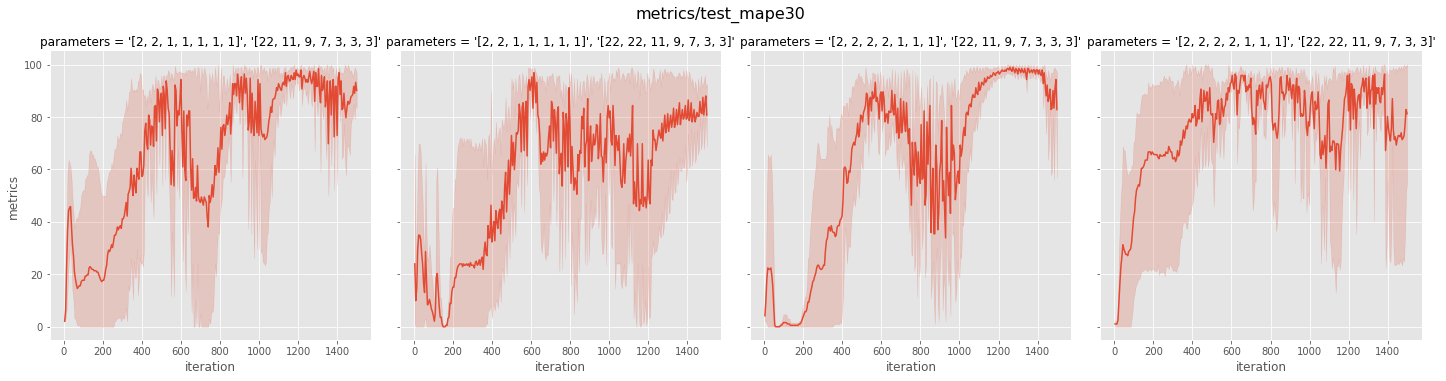

In [47]:
draw_history(research=res, names=['test_mape30'], types_var=['loss', 'metrics'], cross_val=None, aggr=False, iter_start=1)

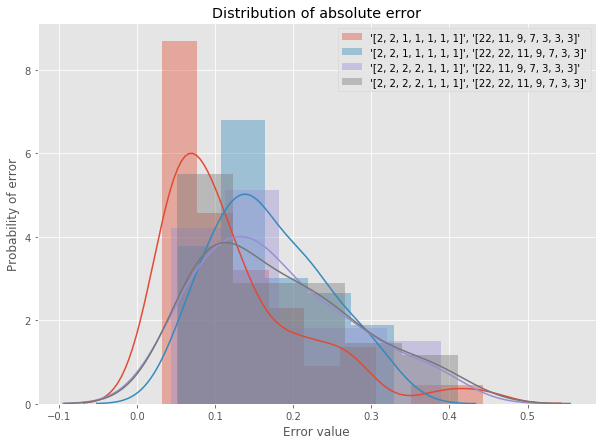

In [48]:
draw_hisogram([res], name='test_ape', type_var='metrics', cross_val=cross_val)

Обучим модель с найденными параметрами на всем обучающем множестве

In [52]:
train_index = FilesIndex(path='npz_data/train_npz/*.npz', no_ext=True)
train_set = Dataset(train_index, batch_class=TmpBatch)

In [53]:
model_config = {
    'inputs': dict(images=dict(shape=(180, 270, 1)),
                             labels={'shape': (1), 'name': 'targets'}),
    'body': dict(layout='cpna cpna cpna cpna cpna cpna cpna', filters=[16, 16, 16, 32, 64, 128, 128],
                 strides=1, pool_strides=2, kernel_size=[22, 11, 9, 7, 3, 3, 3], dilation_rate=[2, 2, 2, 2, 1, 1, 1]),
    'head': dict(layout='Pf', units=1),
    'initial_block/inputs': 'images',
    'loss': 'mse',
    'optimizer': 'Adam'}

train_pipeline = (load_ppl + 
                  Pipeline()
                 .init_variable('loss')
                 .init_variable('mean_loss_history', init_on_each_run=list)
                 .init_variable('loss_history', init_on_each_run=0)
                 .init_model('dynamic', TFModel, 'model', config=model_config)
                 .train_model('model', fetches=['loss', 'TFModel/mean_squared_error/SquaredDifference:0'],
                           feed_dict={'images': B('images'),
                                      'labels': B('target')}, 
                           save_to=[V('loss'), V('loss_history')], mode='w')
                 .update_variable('mean_loss_history', V('loss'), mode='a')
                 .update_loss_history_dict()) << train_set

In [54]:
train_pipeline.run(B_SIZE, n_epochs=80, drop_last=True, lazy=False, bar=True)


 55%|█████▌    | 839/1520 [05:08<04:04,  2.79it/s]  File "../radial/batchflow/batchflow/decorators.py", line 141, in _call_post_fn
  File "/usr/lib/python3.5/concurrent/futures/_base.py", line 398, in result
    return self.__get_result()
  File "/usr/lib/python3.5/concurrent/futures/_base.py", line 357, in __get_result
    raise self._exception
  File "/usr/lib/python3.5/concurrent/futures/thread.py", line 55, in run
    result = self.fn(*self.args, **self.kwargs)
  File "../radial/core/radial_batch.py", line 238, in drop_negative


[IndexError('boolean index did not match indexed array along dimension 0; dimension is 527 but corresponding boolean dimension is 529',)]



100%|██████████| 1520/1520 [09:09<00:00,  2.84it/s]


In [55]:
train_pipeline.get_model_by_name('model')

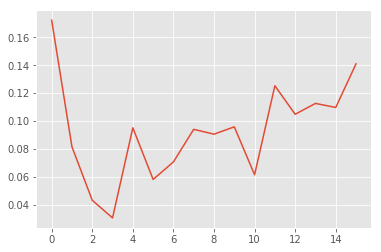

In [57]:
plt.plot(train_pipeline.get_variable('loss_history'))

In [58]:
train_pipeline.save_model('model', 'hard_saved_models/best_model')

In [59]:
test_index = FilesIndex(path='npz_data/npz_with_predictions/*.npz', no_ext=True)
test_set = Dataset(test_index, batch_class=TmpBatch)

In [60]:
test_set.index

In [68]:
predict_pipeline = (load_ppl + 
                 Pipeline()
                  .init_variable('loss', init_on_each_run=0)
                  .init_variable('loss_history', init_on_each_run=list)
                  .init_variable('targets', init_on_each_run=list)
                  .init_variable('predictions', init_on_each_run=list)
                  .init_model('dynamic', TFModel, 'model',
                        config={'load': {'path': 'saved_models/hard_best/'}, 'build': False})
                  .predict_model('model', fetches='predictions',
                               feed_dict={'images': B('images'),
                                          'labels': B('target')}, 
                               save_to=B('predictions'), mode='w')
                  .update_variable('loss_history', V('loss'), mode='a')
                  .denormalize(src='predictions', dst='denorm_predictions',
                               src_range='derivative_range')
                  .update_variable('targets', B('log_target'), mode='e')
                  .update_variable('predictions', B('denorm_predictions'), mode='e')
                ).run(B_SIZE, n_epochs=1, drop_last=True, lazy=True)

In [69]:
btch = (predict_pipeline << test_set).next_batch(len(test_set.indices))

graph files ['saved_models/hard_best/model-1500.meta']
all steps  [1500]
INFO:tensorflow:Restoring parameters from saved_models/hard_best/model-1500


In [70]:
metrics = np.abs(btch.denorm_predictions.reshape(-1) - btch.log_target.reshape(-1)) / btch.log_target.reshape(-1)
metrics = metrics.astype(np.float32)

(array([2., 4., 3., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.33013591, 0.48630179, 0.64246767, 0.79863354, 0.95479942,
        1.1109653 , 1.26713117, 1.42329705, 1.57946293, 1.7356288 ,
        1.89179468]),
 <a list of 10 Patch objects>)

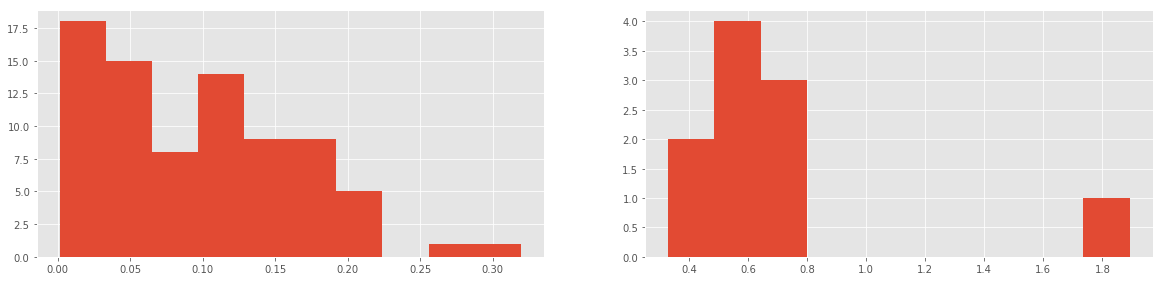

In [71]:
plt.figure(1, figsize=(20, 10))
plt.subplot(221)
plt.hist(np.sort(metrics)[:-10])
plt.subplot(222)
plt.hist(np.sort(metrics)[-10:])

In [72]:
print('Average metrics is', np.mean(metrics < 0.3) * 100)

Average metrics is 87.77777777777777
